# AMAZON REVIEWS ANALYSIS

This assignment was developed utilizing PySpark. However, due to resource limitations, the full dataset could not be processed. Therefore, a subset was used to test the logic of the various sections. This assignment possesses a Sample Mode to facilitate this testing.

In [1]:
# pip install pyspark --default-timeout=100

In [3]:
import os
import subprocess
import sys

In [5]:
'''
#Code to set JAVA HOME and Create Environment for Spark Session
os.environ["JAVA_HOME"] = "C:/Users/student/Desktop/Lillian Charles/Y3 S2/COMP 3610 - Big Data/Assignments/Java/jdk8u452-b09"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "\\bin;" + os.environ["PATH"]

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
'''

In [7]:
#Code to Check Java Setup
print("JAVA_HOME:", os.environ.get("JAVA_HOME"))

try:
    result = subprocess.run(["java", "-version"], capture_output=True, text=True)
    print(result.stderr)
except Exception as e:
    print("Error running java:", e)

JAVA_HOME: C:/Users/student/Desktop/Lillian Charles/Y3 S2/COMP 3610 - Big Data/Assignments/Java/jdk8u452-b09
openjdk version "1.8.0_452"
OpenJDK Runtime Environment (Temurin)(build 1.8.0_452-b09)
OpenJDK 64-Bit Server VM (Temurin)(build 25.452-b09, mixed mode)



In [9]:
#Creating the Spark Session
from pyspark.sql import SparkSession 

spark = SparkSession.builder.appName("Amazon Review Project").config("spark.driver.memory", "12g").getOrCreate()

In [11]:
from datasets import load_from_disk, concatenate_datasets
from pyspark.sql.functions import col, udf, size, split, to_timestamp, year
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
import pandas as pd

## SAMPLE TESTING

This allows the program to be run on a sample of the dataset stored as a csv. To use sample mode, set SAMPLE_MODE to True otherwose, set to FALSE. If Sample mode is being utilized, the Process Categories section should not be run.

In [103]:
schema = StructType([
    StructField("asin", StringType(), True),
    StructField("author", StringType(), True),
    StructField("average_rating", DoubleType(), True),
    StructField("bought_together", StringType(), True),
    StructField("brand", StringType(), True),
    StructField("categories", StringType(), True),
    StructField("description", StringType(), True),
    StructField("details", StringType(), True),
    StructField("features", StringType(), True),
    StructField("helpful_vote", IntegerType(), True),
    StructField("images_x", StringType(), True),
    StructField("images_y", StringType(), True),
    StructField("main_category", StringType(), True),
    StructField("parent_asin", StringType(), True),
    StructField("price", StringType(), True),
    StructField("rating", DoubleType(), True),
    StructField("rating_number", IntegerType(), True),
    StructField("review_length", IntegerType(), True),
    StructField("store", StringType(), True),
    StructField("subtitle", StringType(), True),
    StructField("text", StringType(), True),
    StructField("timestamp", StringType(), True),
    StructField("title_x", StringType(), True),
    StructField("title_y", StringType(), True),
    StructField("user_id", StringType(), True),
    StructField("verified_purchase", StringType(), True),
    StructField("videos", StringType(), True),
    StructField("year", IntegerType(), True),
])

In [113]:
''' #Uncomment to use Sample Mode
from pyspark.sql.functions import year

SAMPLE_MODE = True   # Change to False to run on the full dataset

#Load CSV 
merged_df = spark.read.csv("clean_output.csv", header=True, inferSchema=True, multiLine=True, escape='"', quote='"')

#If sample mode is on, use a smaller subset
if SAMPLE_MODE:
    merged_df = merged_df.limit(10000)  # Adjust the number to fit machine's capacity

print("Using sample data for development." if SAMPLE_MODE else "Running on full dataset.")
'''

Using sample data for development.


## Process Categories

This section loads all the stored categories into the program and merges them into a singular dataframe. It utilized the load_and_process_categories function on each category present in VALID_CATEGORIES.

<strong> NOTE: If sample mode is on, DO NOT RUN this section </strong>

In [13]:
# Function to convert rows in the data to String. Prevents inference errors
import json

def stringify_fields(rows, fields):
    for row in rows:
        for field in fields:
            if field in row and row[field] is not None:
                try:
                    row[field] = json.dumps(row[field])
                except:
                    row[field] = str(row[field])
    return rows

In [15]:
# Function to remove empyt columns from the dataset
def remove_empty_columns(rows):
    if not rows:
        return rows
    keys = list(rows[0].keys())
    for key in keys:
        if all(row.get(key) is None for row in rows):
            for row in rows:
                row.pop(key, None)
    return rows

In [17]:
from pyspark.sql.types import *

#Function to automatically set the schema for the datasets.
def infer_spark_schema(sample_row):
    type_mapping = {
        str: StringType(),
        int: IntegerType(),
        float: FloatType(),
        bool: BooleanType(),
        type(None): StringType()  # Treat None as StringType
    }

    fields = []
    for key, value in sample_row.items():
        if isinstance(value, (dict, list)):
            fields.append(StructField(key, StringType(), True))  # stringify complex stuff
        else:
            spark_type = type_mapping.get(type(value), StringType())
            fields.append(StructField(key, spark_type, True))
    
    return StructType(fields)

In [19]:
# Function to load the categories into the program and execute data cleaning
def load_and_process_categories(base_path, category):

    print(f"⚙️ Loading category {category}...")
    
    review_path = os.path.join(base_path, f"raw_review_{category}")
    meta_path = os.path.join(base_path, f"raw_meta_{category}")

    review_data = load_from_disk(review_path)["full"]
    meta_data = load_from_disk(meta_path)["full"]
    
    review_rows = review_data.to_list()
    meta_rows = meta_data.to_list()

   # Auto schema: meta
    meta_schema = infer_spark_schema(meta_rows[0])

    # Stringify problematic fields
    problem_fields = ["images", "features", "description", "specs", "feature_vectors"]
    review_rows = stringify_fields(review_rows, problem_fields)
    meta_rows = stringify_fields(meta_rows, problem_fields)

    review_rows = remove_empty_columns(review_rows)
    meta_rows = remove_empty_columns(meta_rows)

    # Create Spark DataFrames safely
    try:
        review_schema = infer_spark_schema(review_rows[0])
        review_df = spark.createDataFrame(review_rows, schema=review_schema)
    except Exception as e:
        print(f"\n Error: Could not infer schema for review in {category}: {e}.Using Spark's automatic inference.\n")
        review_df = spark.createDataFrame(review_rows)
    
    meta_df = spark.createDataFrame(meta_rows, schema=meta_schema)


    for col_name in ["images", "title"]:
        if col_name in meta_df.columns:
            meta_df = meta_df.withColumnRenamed(col_name, f"{col_name}_meta")
        
    # Merge on parent_asin
    merged_df = review_df.join(meta_df, on="parent_asin", how="left")

    #Drop rows where rating is missing or not in [1–5], drop rows if text (the review body) is empty or null
    merged_df = merged_df.filter((col("rating").between(1, 5) & (col("Text").isNotNull()) & (col("text") != "")))

    def get_brand(details, store):
        if isinstance(details, dict) and "brand" in details:
            return details["brand"]
        return store if store else "Unknown"

    brand_udf = udf(get_brand, StringType())
    merged_df = merged_df.withColumn("brand", brand_udf(col("details"), col("store")))

    # Remove duplicates
    merged_df = merged_df.dropDuplicates(["user_id", "asin", "text"])

    # Derived columns
    merged_df = merged_df.withColumn("review_length",size(split(col("text"), "")))
    merged_df = merged_df.withColumn("timestamp", to_timestamp((col("timestamp")/1000).cast("long")))
    merged_df = merged_df.withColumn("year", year(col("timestamp")))

    return merged_df

In [ ]:
from bigdata_a3_utils import VALID_CATEGORIES

# Path where files are stored
base_path = "./review_files"
all_dfs = [] # array to hold the processed and loaded categories

# Code to split the categories into batches for processing
batch_size = 5
category_batches = [VALID_CATEGORIES[i:i + batch_size] for i in range(0, len(VALID_CATEGORIES), batch_size)]

In [ ]:
# Categories already processed
processed_categories = set([cat for cat, _ in all_dfs])

# loop to process categories
for category in category_batches:
        
    if category in processed_categories:
        print(f"⏭️ Skipping {category}, already processed. \n\n")
        continue
            
    try:
        df = load_and_process_categories(base_path, category)
    
        all_dfs.append((category, df))
    
        print(f"✅ {category} addedd to all_dfs \n\n")
    
        del df
    
    except Exception as e:
        print(f"❌ Failed on {category}: {e} \n\n")

In [25]:
# Extract the DataFrames from the (category, df) tuples
dfs_only = [df for _, df in all_dfs]

# Start with the first DataFrame
merged_df = dfs_only[0]

# Union the rest of them
for df in dfs_only[1:]:
    merged_df = merged_df.unionByName(df, allowMissingColumns=True)

##  Unified Output

In [19]:
merged_df.printSchema()

root
 |-- rating: double (nullable = true)
 |-- title_x: string (nullable = true)
 |-- text: string (nullable = true)
 |-- images_x: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- helpful_vote: integer (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- main_category: string (nullable = true)
 |-- title_y: string (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- rating_number: integer (nullable = true)
 |-- features: string (nullable = true)
 |-- description: string (nullable = true)
 |-- price: double (nullable = true)
 |-- images_y: string (nullable = true)
 |-- videos: string (nullable = true)
 |-- store: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- details: string (nullable = true)
 |-- bought_together: double (nullable = true)
 |-- subtitle: string (nullable = true)
 |-- author

In [135]:
#Outputting the count of reviews in each year 
merged_df.groupBy("year").count().orderBy("year").show()

+----+-----+
|year|count|
+----+-----+
|2003|    2|
|2004|    3|
|2005|    3|
|2006|    5|
|2007|   11|
|2008|    8|
|2009|   12|
|2010|   21|
|2011|   21|
|2012|   36|
|2013|  107|
|2014|  232|
|2015|  542|
|2016|  905|
|2017|  844|
|2018| 1025|
|2019| 1312|
|2020| 2075|
|2021| 1861|
|2022|  867|
+----+-----+
only showing top 20 rows



In [101]:
merged_df.show(5)

+------+--------------------+--------------------+--------+----------+-----------+--------------------+-------------+------------+-----------------+-------------+--------------------+--------------+-------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+----------+--------------------+---------------+--------+------+--------------------+-------------+----+
|rating|             title_x|                text|images_x|      asin|parent_asin|             user_id|    timestamp|helpful_vote|verified_purchase|main_category|             title_y|average_rating|rating_number|            features|         description|price|            images_y|              videos|               store|categories|             details|bought_together|subtitle|author|               brand|review_length|year|
+------+--------------------+--------------------+--------+----------+-----------+--------------------+-------------+------------+--------------

## Exploratory Data Analysis (EDA)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

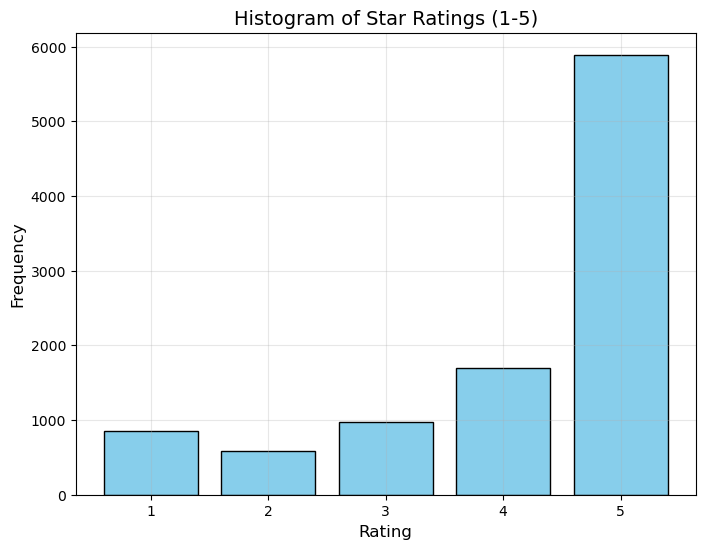

In [27]:
#Star Rating Histogram
filtered_ratings = merged_df.filter((col("rating") >= 1) & (col("rating") <= 5))

rating_counts = filtered_ratings.groupBy("rating").count().orderBy("rating")

rating_counts_pd = rating_counts.limit(10).toPandas()

# Plotting the histogram
plt.figure(figsize=(8, 6))
plt.bar(rating_counts_pd['rating'], rating_counts_pd['count'], color='skyblue', edgecolor='black')
plt.title('Histogram of Star Ratings (1-5)', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(range(1, 6))  # Set x-ticks to be the star ratings 1-5
plt.grid(True, alpha=0.3)
plt.show()

<strong>The following function can only be run if Sample Mode is set to False </strong>

In [ ]:
#Bar chart showing top 10 categories
category_counts = merged_df.groupBy("category").count().orderBy("count", ascending=False)

top_10_categories = category_counts.limit(10)

top_10_categories_pd = top_10_categories.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(top_10_categories_pd['category'], top_10_categories_pd['count'], color='orange', edgecolor='black')
plt.title('Top 10 Categories by Total Review Count', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Total Review Count', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate category names for better readability
plt.grid(True, alpha=0.3)
plt.show()


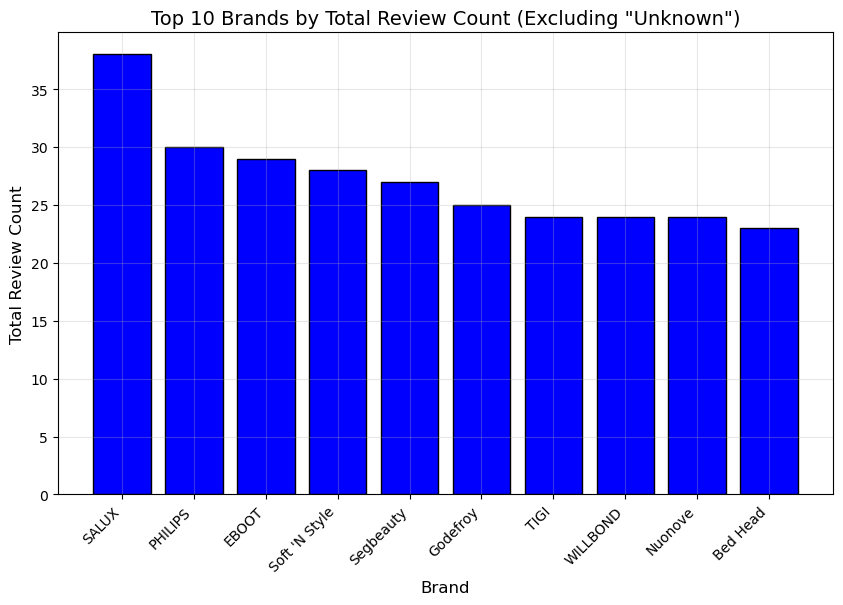

In [29]:
#Bar chart showing top 10 brands (excluding "Unknown")
filtered_df = merged_df.filter(merged_df["brand"] != "Unknown")

brand_counts = filtered_df.groupBy("brand").count().orderBy("count", ascending=False)

top_10_brands = brand_counts.limit(10)

top_10_brands_pd = top_10_brands.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(top_10_brands_pd['brand'], top_10_brands_pd['count'], color='blue', edgecolor='black')
plt.title('Top 10 Brands by Total Review Count (Excluding "Unknown")', fontsize=14)
plt.xlabel('Brand', fontsize=12)
plt.ylabel('Total Review Count', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate brand names for better readability
plt.grid(True, alpha=0.3)
plt.show()


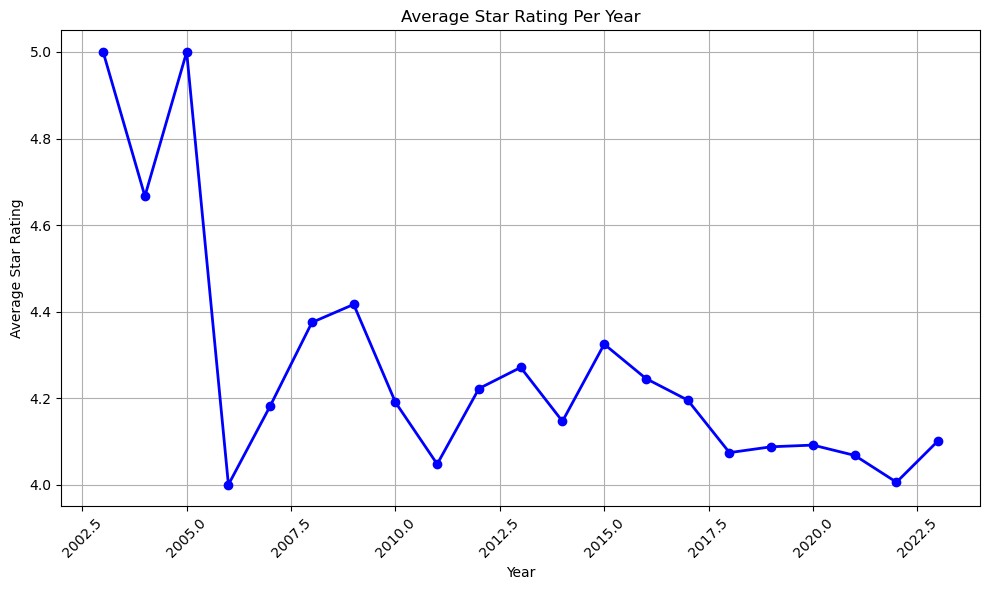

In [115]:
#Line chart of average star rating per year
from pyspark.sql import functions as F

time_based_trend = (merged_df.filter(col("rating").isNotNull()).groupBy("year").agg(F.avg("rating").alias("avg_rating")).orderBy("year"))

time_based_trend_pd = time_based_trend.toPandas()

# Step 3: Plot the time-based trend
plt.figure(figsize=(10, 6))
plt.plot(time_based_trend_pd['year'], time_based_trend_pd['avg_rating'], marker='o', color='b', linestyle='-', linewidth=2, markersize=6)
plt.title('Average Star Rating Per Year')
plt.xlabel('Year')
plt.ylabel('Average Star Rating')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
#Calculate Pearson correlation
from pyspark.sql.functions import length, col

merged_df_with_length = merged_df.withColumn('review_length', length(col('text')))

correlation = merged_df_with_length.stat.corr('review_length', 'rating')

print(f"Pearson Correlation between review length and star rating: {correlation}")

Pearson Correlation between review length and star rating: 0.00943575303479137


## Binary Sentiment Prediction (Logistic Regression)

In [35]:
from pyspark.sql.functions import when, col

# Create binary sentiment label: 1 = positive, 0 = negative
binary_df = merged_df.withColumn("label", when(col("rating") >= 4, 1).otherwise(0)).select("label", "text")

In [37]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline

#Setting up text for Model Training
tokenizer = Tokenizer(inputCol="text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
tf = HashingTF(inputCol="filtered", outputCol="raw_features", numFeatures=10000)
idf = IDF(inputCol="raw_features", outputCol="features")

In [39]:
from pyspark.ml.classification import LogisticRegression

#Regression Model
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10)

In [41]:
pipeline = Pipeline(stages=[tokenizer, remover, tf, idf, lr])

In [67]:
# Train Test Split on a Random Set
small_sample = binary_df.sample(fraction=0.10, seed=42)

train_data, test_data = small_sample.randomSplit([0.8, 0.2], seed=42)

model = pipeline.fit(train_data)
predictions = model.transform(test_data)

In [69]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

print(f"AUC: {roc_auc:.4f}")

AUC: 0.6001


In [71]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1"
)

f1_score = evaluator_f1.evaluate(predictions)
print(f"F1 Score: {f1_score:.4f}")

F1 Score: 0.6965


In [73]:
confusion_df = predictions.groupBy("label", "prediction").count().orderBy("label", "prediction")
confusion_df.show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|   17|
|    0|       1.0|   25|
|    1|       0.0|   32|
|    1|       1.0|  109|
+-----+----------+-----+



## Recommender System (ALS)

In [75]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

In [77]:
ratings_df = merged_df.select("user_id", "asin", "rating") \
    .dropna() \
    .withColumn("user_id", merged_df["user_id"].cast("string")) \
    .withColumn("asin", merged_df["asin"].cast("string")) \
    .withColumn("rating", merged_df["rating"].cast("float"))

In [79]:
# Converting string IDs to numeric
from pyspark.ml.feature import StringIndexer
user_indexer = StringIndexer(inputCol="user_id", outputCol="user_index").fit(ratings_df)
item_indexer = StringIndexer(inputCol="asin", outputCol="item_index").fit(ratings_df)

indexed = user_indexer.transform(ratings_df)
indexed = item_indexer.transform(indexed)

In [81]:
# ALS model
als = ALS(
    userCol="user_index",
    itemCol="item_index",
    ratingCol="rating",
    coldStartStrategy="drop",  # drops rows with NaN predictions
    implicitPrefs=False
)

model = als.fit(indexed)

In [82]:
# Evaluate
predictions = model.transform(indexed)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)

print(f"RMSE: {rmse:.4f}")

RMSE: 0.0780


## Clustering

In [125]:
from pyspark.sql.functions import avg, count
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.clustering import KMeans

product_stats = merged_df.groupBy("asin").agg(
    avg("rating").alias("mean_rating"),
    count("rating").alias("total_reviews")
)


product_meta = merged_df.select("asin", "brand", "main_category").dropDuplicates(["asin"])


brand_indexer = StringIndexer(inputCol="brand", outputCol="brand_id")
product_meta = brand_indexer.fit(product_meta).transform(product_meta)


category_indexer = StringIndexer(inputCol="main_category", outputCol="category_id")
product_meta = category_indexer.fit(product_meta).transform(product_meta)


product_features = product_stats.join(product_meta.select("asin", "brand_id", "category_id"), on="asin", how="left")


assembler = VectorAssembler(
    inputCols=["mean_rating", "total_reviews", "brand_id", "category_id"],
    outputCol="features"
)

final_df = assembler.transform(product_features)

final_df.select("asin", "mean_rating", "total_reviews", "brand_id", "category_id", "features").show(20, truncate=False)

+----------+-----------+-------------+--------+-----------+--------------------+
|asin      |mean_rating|total_reviews|brand_id|category_id|features            |
+----------+-----------+-------------+--------+-----------+--------------------+
|B00YQ6X8EO|5.0        |1            |159.0   |0.0        |[5.0,1.0,159.0,0.0] |
|B081TJ8YS3|4.0        |1            |4020.0  |0.0        |[4.0,1.0,4020.0,0.0]|
|B07PNNCSP9|5.0        |1            |3159.0  |0.0        |[5.0,1.0,3159.0,0.0]|
|B09JS339BZ|1.0        |1            |4491.0  |0.0        |[1.0,1.0,4491.0,0.0]|
|B08BZ63GMJ|5.0        |1            |4323.0  |0.0        |[5.0,1.0,4323.0,0.0]|
|B00R8DXL44|4.0        |1            |20.0    |0.0        |[4.0,1.0,20.0,0.0]  |
|B099DRHW5V|5.0        |1            |1128.0  |0.0        |[5.0,1.0,1128.0,0.0]|
|B088SZDGXG|3.0        |1            |796.0   |0.0        |[3.0,1.0,796.0,0.0] |
|B08P2DZB4X|5.0        |2            |3169.0  |0.0        |[5.0,2.0,3169.0,0.0]|
|B086QY6T7N|5.0        |1   

In [129]:
kmeans = KMeans(featuresCol="features", k=5, seed=1)
model = kmeans.fit(final_df)

clustered = model.transform(final_df)
clustered.select("asin", "prediction").show()

+----------+----------+
|      asin|prediction|
+----------+----------+
|B00YQ6X8EO|         1|
|B081TJ8YS3|         2|
|B07PNNCSP9|         0|
|B09JS339BZ|         2|
|B08BZ63GMJ|         2|
|B00R8DXL44|         1|
|B099DRHW5V|         4|
|B088SZDGXG|         4|
|B08P2DZB4X|         0|
|B086QY6T7N|         3|
|B08DHTJ25J|         2|
|B07RBSLNFR|         4|
|B07SLFWZKN|         4|
|B08JTNQFZY|         1|
|B08GLG6W8T|         3|
|B08M3C6LVS|         3|
|B07GHPCT6T|         3|
|B07KG1TWP5|         4|
|B07W397QG4|         1|
|B07GDQPG12|         4|
+----------+----------+
only showing top 20 rows

